## Mateusz Strojek, Bartłomiej Sadza
### IiE 1 rok stacjonarnie
### Machine learning - ćwiczenia 7

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score
from imblearn.over_sampling import RandomOverSampler

### Oczyszczenie danych

In [135]:
data = pd.read_csv("stroke_zad7.csv", delimiter=";")
df= data.copy()
print(df.isnull().sum())
print(df.dtypes)
df.head()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
gender               object
age                  object
hypertension          int64
heart_disease         int64
ever_married         object
work_type            object
Residence_type       object
avg_glucose_level    object
bmi                  object
smoking_status       object
stroke                int64
dtype: object


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,"228,69","36,6",formerly smoked,1
1,Female,61,0,0,Yes,Self-employed,Rural,"202,21","34,55",never smoked,1
2,Male,80,0,1,Yes,Private,Rural,"105,92","32,5",never smoked,1
3,Female,49,0,0,Yes,Private,Urban,"171,23","34,4",smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,"174,12",24,never smoked,1


### Zamiana na odpowiedni typ danych

In [137]:
def czy_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

df.loc[df['age'].apply(czy_float)==False, "age"] = np.nan
df['age'] = df['age'].astype('float')
df['avg_glucose_level'] = df['avg_glucose_level'].str.replace(',', '.')
df['avg_glucose_level'] = df['avg_glucose_level'].astype('float')
df['bmi'] = df['bmi'].str.replace(',', '.')
df['bmi'] = df['bmi'].astype('float')
df= df.dropna()
print(df.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [138]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60,1,True,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,34.55,1,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.50,1,True,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.40,1,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.00,1,False,True,False,False,True,False,False,False,True,False


In [139]:
df_clean = df.copy()

## **Zadanie 1.** Modelowanie niezbalansowanego zbioru danych

### a) Przygotować zbiór danych (zweryfikować poziom niezbalansowania zbioru danych, dokonać podziału na zbiór uczący i testowy).

In [142]:
X = df_clean.drop(columns='stroke')
y = df_clean['stroke']

imbalance_ratio = y.value_counts(normalize=True)
print('Stopień niezbalansowania:')
print(imbalance_ratio)

Stopień niezbalansowania:
stroke
0    0.95034
1    0.04966
Name: proportion, dtype: float64


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### 95% obserwacji zmiennej objaśnianej przyjmuje wartości 0, a reszta przyjmuje wartość 1.

### b) Korzystając z wybranej metody zbudować model przewidujący wystąpienie udaru. Przeanalizować wartości dokładności, czułości i specyficzności dla tej klasyfikacji.

In [146]:
clf = RandomForestClassifier(random_state=2, max_depth=8)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

wyniki = []
wyniki.append({
        'type' : 'No-edit',
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'train_recall': recall_score(y_train, y_pred_train),
        'test_recall': recall_score(y_test, y_pred_test),
        'train_precision': precision_score(y_train, y_pred_train),
        'test_precision': precision_score(y_test, y_pred_test)
    })

df = pd.DataFrame(wyniki)
print(df)

      type  train_accuracy  test_accuracy  train_recall  test_recall  \
0  No-edit        0.956195       0.940941      0.074074          0.0   

   train_precision  test_precision  
0              1.0             0.0  


C:\Users\matti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Wyniki lasu losowego kształtują się następująco:
- dokładność (accuracy) dla zbioru treningowego - 95.6%
- czułość (recall) dla zbioru treningowego - 7.4%
- precyzja (precision) dla zbioru treningowego - 100%
- dokładność (accuracy) dla zbioru uczącego - 94.1%
- czułość (recall) dla zbioru uczącego - 0%
- precyzja (precision) dla zbioru uczącego - 0%
#### Predykcja jest bardzo słaba, jeśli chcemy mieć wysoką czułość i precyzję.

### c) Zweryfikować, jak poszczególne techniki resamplingu (oversampling i undersampling) wpływają na uzyskiwane wartości oceny modelu. Zwrócić przede wszystkim uwagę na dokładność, czułość i specyficzność

In [149]:
smote=SMOTE(random_state=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
clf_smote = RandomForestClassifier(random_state=2, max_depth=8)
clf_smote.fit(X_train_smote, y_train_smote)
y_pred_test = clf_smote.predict(X_test)
y_pred_train = clf_smote.predict(X_train)


wyniki = []
wyniki.append({
        'type' : 'oversampling',
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'train_recall': recall_score(y_train, y_pred_train),
        'test_recall': recall_score(y_test, y_pred_test),
        'train_precision': precision_score(y_train, y_pred_train),
        'test_precision': precision_score(y_test, y_pred_test)
    })

df_ov = pd.DataFrame(wyniki)

In [150]:
undersampler = RandomUnderSampler(random_state=2)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
clf_under = RandomForestClassifier(random_state=2, max_depth=8)
clf_under.fit(X_train_under, y_train_under)
y_pred_test = clf_under.predict(X_test)
y_pred_train = clf_under.predict(X_train)

wyniki = []
wyniki.append({
        'type' : 'undersampling',
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'train_recall': recall_score(y_train, y_pred_train),
        'test_recall': recall_score(y_test, y_pred_test),
        'train_precision': precision_score(y_train, y_pred_train),
        'test_precision': precision_score(y_test, y_pred_test)
    })

df_und = pd.DataFrame(wyniki)

In [151]:
df_all = pd.concat([df, df_ov, df_und])
df_all

,type,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision
0,No-edit,0.956195,0.940941,0.074074,0.000000,1.000000,0.000000
0,oversampling,0.881602,0.847848,0.687831,0.372881,0.238971,0.160584
0,undersampling,0.702879,0.704705,0.973545,0.813559,0.134700,0.144578


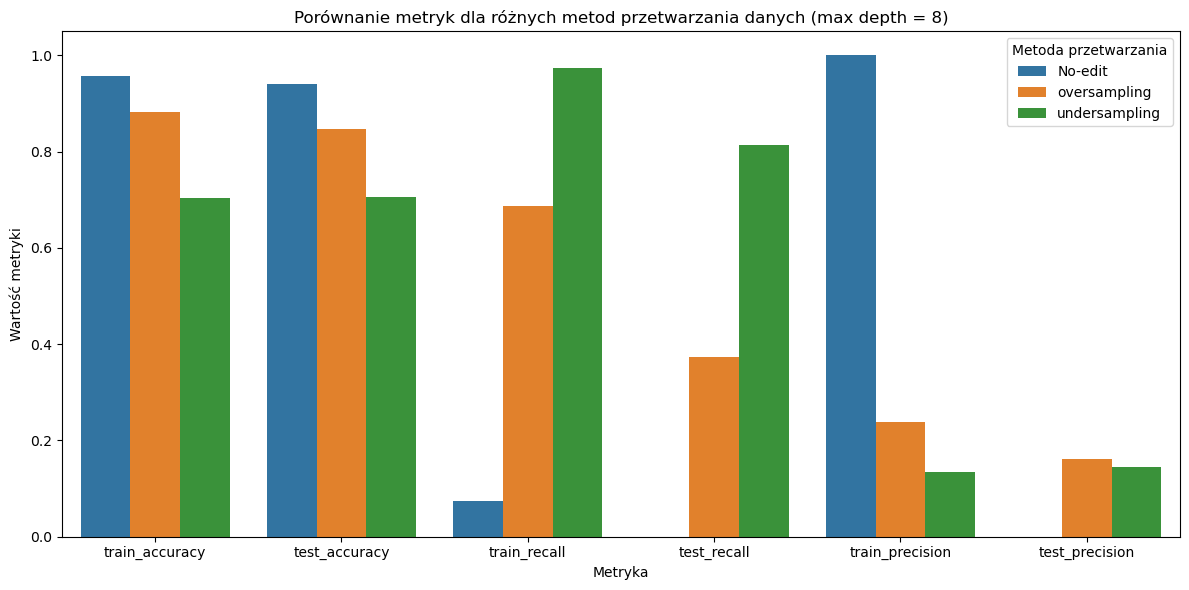

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt


df_melted = df_all.melt(id_vars=["type"], var_name="metric", value_name="value")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="metric", y="value", hue="type")
plt.title("Porównanie metryk dla różnych metod przetwarzania danych (max depth = 8)")
plt.ylabel("Wartość metryki")
plt.xlabel("Metryka")
plt.legend(title="Metoda przetwarzania")
plt.tight_layout()
plt.show()

#### Dla zbioru treningowego:
- Dokładność była najwyższa dla modelu bez edycji liczby obserwacji (ok. 96%), potem oversampling (88%) i undersampling (70%)
- Czułość była najwyższa dla undersamplingu (97%), (69%) dla oversamplingu, (7%) bez edycji liczby obserwacji
- Precyzja była najwyższa dla modelu bez edycji liczby obserwacji (100%), (24%) dla oversamplingu, (13%) dla undersamplingu
#### Dla zbioru testowego:
- Dokładność była najwyższa dla modelu bez edycji liczby obserwacji (ok. 94%), potem oversampling (85%) i undersampling (70%)
- Czułość była najwyższa dla undersamplingu (81%), (37%) dla oversamplingu, (0%) bez edycji liczby obserwacji
- Precyzja była najniższa dla modelu bez edycji liczby obserwacji (0%), (16%) dla oversamplingu, (14%) dla undersamplingu

### d) Opisać wykorzystane w poprzednim podpunkcie techniki oversamplingu i undersamplingu (znaleźć w dokumentacji lub innych źródłach, jak dane funkcje w R/Pythonie działają - w jaki sposób eliminują problem niezbalansowanego zbioru danych).

#### **SMOTE** (Synthetic Minority Oversampling Technique) - najpierw wybierana jest losowo obserwacja z klasy mniejszościowej, przeprowadzany jest algorytm KNN, wybiera się losowego sąsiada losowo wybranej obserwacji oraz obliczana jest nowa obserwacja na podstawie wzoru:
#### Nowa obserwacja = Stara obserwacja + r * (Sąsiad - Stara obserwacja), gdzie r to losowa wartość z przedziału [0,1]. Przykład:
- Nowa obserwacja = [1.0,2.0,3.0]+0.6⋅([1.5,2.5,3.5]−[1.0,2.0,3.0]) = [1.3,2.3,3.3]


#### **RandomUnderSampler** - metoda ta polega na tym, że obserwacje klasy większościowej są losowo usuwane do momentu, gdy liczba obserwacji jest równa liczbie obserwacji klasy mniejszościowej 

## **Zadanie 2.** Różne stopnie niezbalansowania zbioru danych

### Przeprowadzić symulację, na podstawie której oceniony zostanie wpływ poszczególnych technik resamplingu na uzyskiwane wartości oceny modelu w przypadku różnych udziałów klasy pozytywnej i negatywnej. W tym celu, poprzez losowanie obserwacji, utworzyć w różnym stopniu niezbalansowane zbiory danych. Następnie dla każdego ze stworzonych zbiorów danych zbudować po 3 modele (bez uwzględniania niezbalansowanego zbioru, wykorzystując oversampling, wykorzystując undersampling). Porównać jakość uzyskanych klasyfikacji na podstawie dokładności, specyficzności i czułości (można wykorzystać także inne miary).

C:\Users\matti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


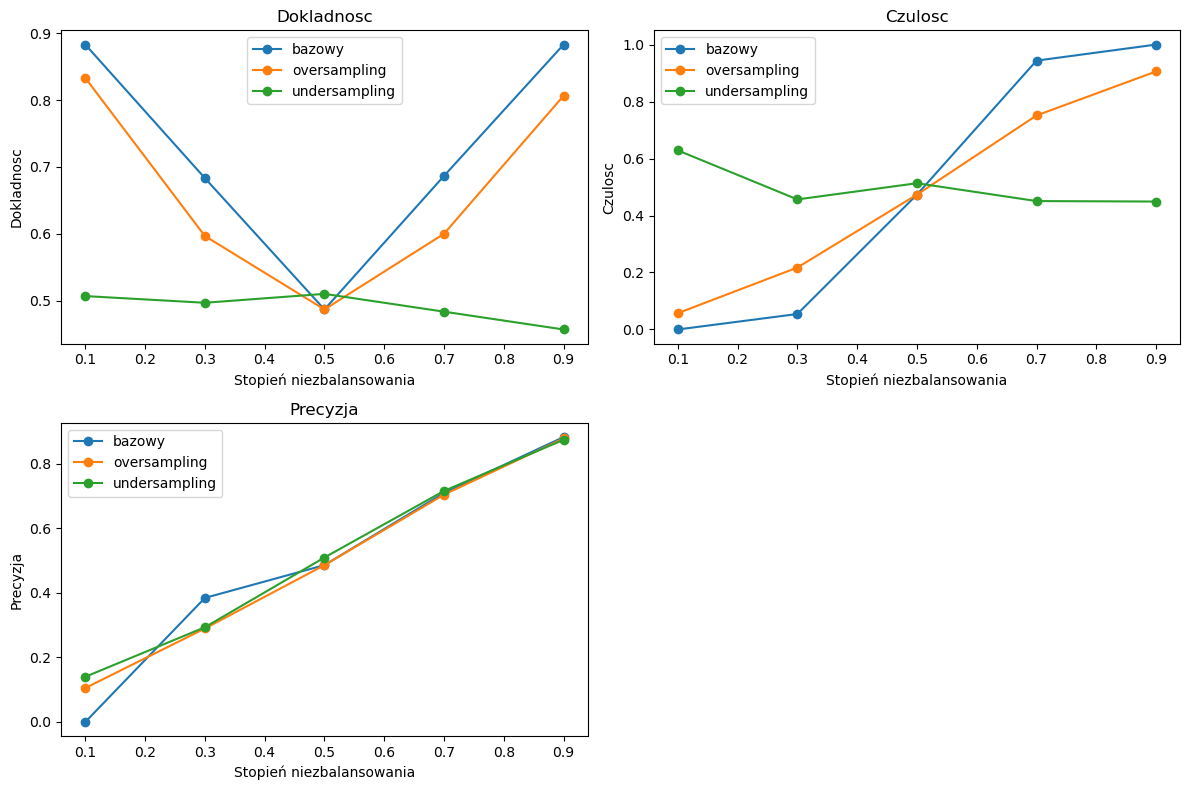

In [172]:
def generuj_dane(rozmiar=1000, stopien_niezbalansowania=0.1):
    np.random.seed(10)
    X = np.random.rand(rozmiar, 10)
    y = np.zeros(rozmiar)
    y[:int(rozmiar * stopien_niezbalansowania)] = 1
    return X, y

def ocen_model(y_prawdziwe, y_przewidywane):
    return {
        "dokladnosc": accuracy_score(y_prawdziwe, y_przewidywane),
        "czulosc": recall_score(y_prawdziwe, y_przewidywane),
        "precyzja": precision_score(y_prawdziwe, y_przewidywane)
    }

def symuluj_resampling():
    wyniki = []
    stopnie_niezbalansowania = [0.1, 0.3, 0.5, 0.7, 0.9]

    for stopien in stopnie_niezbalansowania:
        X, y = generuj_dane(1000, stopien)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = RandomForestClassifier(random_state=4)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metryki_bazowe = ocen_model(y_test, y_pred)
        wyniki.append({"metoda": "bazowy", "stopien_niezbalansowania": stopien, **metryki_bazowe})

        ros = SMOTE(random_state=4)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        metryki_oversampling = ocen_model(y_test, y_pred)
        wyniki.append({"metoda": "oversampling", "stopien_niezbalansowania": stopien, **metryki_oversampling})

        rus = RandomUnderSampler(random_state=2)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        metryki_undersampling = ocen_model(y_test, y_pred)
        wyniki.append({"metoda": "undersampling", "stopien_niezbalansowania": stopien, **metryki_undersampling})

    return pd.DataFrame(wyniki)

def rysuj_wyniki(df):
    metryki = ["dokladnosc", "czulosc", "precyzja"]
    plt.figure(figsize=(12, 8))

    for i, metryka in enumerate(metryki, 1):
        plt.subplot(2, 2, i)
        for metoda in df["metoda"].unique():
            podzbior = df[df["metoda"] == metoda]
            plt.plot(podzbior["stopien_niezbalansowania"], podzbior[metryka], marker='o', label=metoda)

        plt.title(metryka.capitalize())
        plt.xlabel("Stopień niezbalansowania")
        plt.ylabel(metryka.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

wyniki_df = symuluj_resampling()
rysuj_wyniki(wyniki_df)

### **Wnioski z analizy wpływu metod resamplingu na klasyfikację**

#### **1. Model bazowy (bez resamplingu):**
- **Przy niskim stopniu niezbalansowania** (np. 0.1 lub 0.3):
  - Model bazowy osiąga **wysoką dokładność**, ale **bardzo niską czułość** (0.000).
  - Wynika to z ignorowania klasy mniejszościowej, co pozwala zmaksymalizować dokładność.
- **Przy bardziej zbalansowanym zbiorze** (np. stopień niezbalansowania 0.5):
  - Czułość i precyzja zaczynają się poprawiać.
- **Przy dużym udziale klasy pozytywnej** (np. 0.9):
  - Model bazowy osiąga **perfekcyjną czułość (1.000)**, ponieważ klasa mniejszościowa praktycznie nie występuje w zbiorze testowym.

#### **2. Oversampling:**
- **Przy niskim stopniu niezbalansowania (0.1):**
  - Nie przynosi poprawy w porównaniu z modelem bazowym.
- **Przy umiarkowanym niezbalansowaniu (0.3–0.7):**
  - Poprawia **czułość** w porównaniu do modelu bazowego.

#### **3. Undersampling:**
- **Przy niskim stopniu niezbalansowania (0.1):**
  - **Czułość wzrasta do ok. 0.6**, ale kosztem dokładności.
  - Metoda redukuje liczbę danych klasy większościowej, co ułatwia klasyfikację klasy mniejszościowej.
- **Przy umiarkowanym niezbalansowaniu (0.7):**
  - Czułość maleje do ok. (0.45), ale precyzja wzrasta.

#### **4. Ogólne zależności:**
- **Oversampling:**
  - Lepszy w poprawie czułości przy umiarkowanym niezbalansowaniu (0.3–0.5) w porównaniu do modelu bazowego.
- **Undersampling:**
  - Skuteczniejszy przy bardzo niskim stopniu niezbalansowania (np. 0.1) do predykcji klasy mniejszościowej.
- **Model bazowy:**
  - Działa podobnie jak oversampling, przy czym czułość jest nieco lepsza w niezbilansowaniu na poziomie >0.5

### **Podsumowanie:**
1. **Przy dużym niezbalansowaniu (np. 0.1–0.3):**
    - **Undersampling** jest lepszy, jeśli klasa mniejszościowa ma kluczowe znaczenie.

2. **Przy umiarkowanym niezbalansowaniu (np. 0.3–0.5):**
    - **Oversampling** poprawia czułość bez znacznego spadku dokładności.

3. **Przy równomiernym rozkładzie (0.5):**
    - Model bazowy jest wystarczający.

4. **Przy dominacji klasy pozytywnej (np. 0.9):**
    - Resampling jest zbędny, jeśli specyficzność ma minimalne znaczenie.

Wybór odpowiedniej metody resamplingu powinien zależeć od stopnia niezbalansowania danych oraz priorytetów projektu (np. poprawa czułości vs. utrzymanie dokładności). Każda metoda ma swoje zalety i ograniczenia, które należy wziąć pod uwagę w kontekście problemu do rozwiązania.
